<a href="https://colab.research.google.com/github/AfraAd/CSC413-Homeworks/blob/main/Fall25_Hw7_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7 - Attention
CSC413/2516: Neural Networks and Deep Learning

As with previous homeworks, replace "## Your Code" lines with your implementation.


In this homework, you will implement various attention mechanisms to solve
sequence problems. You'll start with basic attention pooling and progressively
build up to multi-head attention with different operations.

Grading:
- Data collation: 0.5
- Attention: 3.8
- Trainer and training: 0.9
- Multi-head attention: 1.3

You don't need to use GPU for this homework.

Version: 1.0.2

Changelog:
- 1.0.1 (Oct 17, 12:01): Changed the default `variable_len=False` to True in the `SequenceData` creation.
- 1.0.2 (Oct 17, 13:57): Added `set_seed` statement before the model creation in the single head attention training loops.

## Set-up

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Literal, Dict, Optional
from torch.utils.data import Dataset, DataLoader, random_split
import random

SEED = 42


def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

set_seed()

# Attention Pooling


First, you will implement a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in [the LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

| Pos 0 | Pos 1 | Pos 2 | Pos 3 | Pos 4 | ... | ... | ... | ... |  ... |  ... |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence except for 2 of the entries, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

The dataset may contain sequences of different lenghts, i.e. one example could have 50 items while another could have only 10. Tensors should have coherent shapes, i.e. each sample should have the same number of items. Your first task is to implement the `collate_fn` where you will append `PAD_ID` to the shorter sequences so that each sequence will appear the same length. Later when you are implementing the model, you will ignore these indices so that the function is computed only on the actual elements of the sequence.

You can read more about how PyTorch's dataloader processes samples [here](https://docs.pytorch.org/docs/stable/data.html).

In [4]:
## don't change the following code

PADDING_ID = 100
NUM_SAMPLES = 1000
MAX_SEQ_LEN = 50


def generate_sequence_problem(
    sequence_length: int = 50,
    k: int = 2,
    problem_type: Literal["add", "multiply", "mask"] = "add",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate a k-way sequence problem.

    Args:
        sequence_length: Length of the sequence
        k: Number of positions to mark (default 2)
        problem_type: 'add', 'multiply', or 'average'

    Returns:
        sequence: tensor of shape (sequence_length, 2)
        target: scalar tensor with the target value

    The sequence has:
    - First dimension: random values in [-1, 1]
    - Second dimension: 0 everywhere except k positions marked with 1

    Targets:
    - 'add': sum of marked values
    - 'multiply': product of marked values
    - 'average': mean of marked values
    """
    sequence = np.zeros((sequence_length, 2))
    ## Randomly sample the numbers in the input sequence
    sequence[:, 0] = np.random.uniform(-1, 1, sequence_length)

    random_indices = np.random.choice(sequence_length, size=k, replace=False)
    sequence[random_indices, 1] = 1

    marked_values = sequence[random_indices, 0]

    if problem_type == "add":
        target = marked_values.sum()
    elif problem_type == "multiply":
        target = marked_values.prod()
    elif problem_type == "average":
        target = marked_values.mean()
    else:
        raise ValueError(f"Unknown problem_type: {problem_type}")

    return torch.tensor(sequence, dtype=torch.float32), torch.tensor(
        [target], dtype=torch.float32
    )


class SequenceData(Dataset):
    def __init__(
        self,
        num_samples: int = NUM_SAMPLES,
        max_seq_len: int = MAX_SEQ_LEN,
        padding_id: int = PADDING_ID,
        k: int = 2,
        problem_type: Literal["add", "multiply", "average"] = "add",
        variable_len: bool = False,
    ) -> None:
        """

        Args:
            k: Number of positions to mark
            variable_len: If True, generate sequences of random length between k and max_seq_len
        """
        super().__init__()
        self.padding_id = padding_id
        self.k = k
        self.max_seq_len = max_seq_len
        data = [
            generate_sequence_problem(
                sequence_length=random.randint(k, MAX_SEQ_LEN)
                if variable_len
                else max_seq_len,
                k=k,
                problem_type=problem_type,
            )
            for _ in range(num_samples)
        ]
        self.X = [d[0] for d in data]
        self.y = [d[1] for d in data]

    def __getitem__(self, index):
        item = {
            "inputs": self.X[index],
            "targets": self.y[index],
        }
        return item

    def __len__(self):
        return len(self.X)


In [5]:
def collate_fn(batch: List[Dict[str, torch.Tensor]]):
    targets = None
    inputs = None
    attention_mask = None
    ##########################################
    ## 0.5 points
    ## TODO: 1. Extract targets from batch
    targets = torch.stack([item['targets'] for item in batch])

    ## TODO: Pad the input so that we can batch process it
    ## Hint: You might want to use `nn.utils.rnn.pad_sequence` with batch_first
    inputs = nn.utils.rnn.pad_sequence(
        [item['inputs'] for item in batch],
        batch_first=True,
        padding_value=PADDING_ID
    )

    ## TODO: We don't want padding indices to be considered for attention
    ## attention_mask should have 1 for PADDING positions and 0 for VALID positions
    ## (This follows the convention used in most attention implementations)
    attention_mask = (inputs == PADDING_ID).any(dim=-1)
    ##########################################
    return {
        "inputs": inputs,
        "targets": targets,
        "attention_mask": attention_mask,
    }



Attention pooling allows a model to reduce a variable-length sequence $\{h_1, h_2, \ldots, h_T\}$ to a fixed-length representation through a learned weighted average:

\begin{align}
e_t &= \mathrm{a}(q, h_t) \quad \text{(compute attention scores)} \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \quad \text{(normalize to probabilities)} \\
c &= \sum_{t = 1}^T \alpha_t h_t \quad \text{(weighted sum)}
\end{align}

The key component is the **attention energy function** $\mathrm{a}(q, h_t)$, which computes how much the model should attend to each position. The query $q$ is a learnable parameter, and $h_t \in \mathbb{R}^d$ is the input at position $t$.

### Attention Mechanisms

You will implement three different attention energy functions:

**1. Bahdanau (Additive) Attention:**
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters.

**2. Multiplicative (Luong) Attention:**
$$\mathrm{a}(q, h_t) = q^\top W_a h_t$$
Similar to Bahdanau but without the $\tanh$ nonlinearity.

**3. Scaled Dot-Product Attention:**
$$\mathrm{a}(q, h_t) = \frac{q^\top h_t}{\sqrt{d}}$$
No weight matrix—just a scaled dot product. The scaling by $\sqrt{d}$ prevents the dot products from becoming too large.


### Network Architecture

The attention pooling layer converts variable-length sequences into fixed-length vectors, allowing you to use it within a standard feed-forward network. A typical architecture is:

```
Input (batch_size, seq_len, input_dim)
↓
Dense Layer (position-wise)
↓
Attention Pooling → (batch_size, hidden_dim)
↓
Dense Layer
↓
Output Layer → (batch_size, output_dim)
```

# Implement Attention

In [6]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau (Additive) Attention Pooling.
    Computes: e_t = q^T tanh(W_a h_t + b_a)
    """
    def __init__(self, hidden_dim: int, query_dim: int):
        """
        Args:
            hidden_dim: Dimension of input features
            query_dim: Dimension of attention space
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim

        ##########################################
        ## TODO: Initialize parameters for Bahdanau attention, 0.2 points
        self.w = nn.Parameter(torch.randn(query_dim, hidden_dim))
        self.b = nn.Parameter(torch.zeros(query_dim))
        self.query = nn.Parameter(torch.randn(query_dim, 1))
        ##########################################

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None,
                values: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input tensor (keys) of shape (batch_size, seq_len, hidden_dim)
            attention_mask: Optional mask of shape (batch_size, seq_len)
                          where True indicates positions to IGNORE (padding)
            values: Optional separate values tensor of shape (batch_size, seq_len, value_dim)
                   If None, use x as values (self-attention)
        """
        # Use x as values if not provided (self-attention)
        if values is None:
            values = x
        ##########################################
        res = None
        attention_weights = None
        ## TODO: Implement Bahdanau attention, 0.8 points
        # 1. Apply weight transformation to keys
        # x: (batch_size, seq_len, hidden_dim)
        # w: (query_dim, hidden_dim)
        # transformed: (batch_size, seq_len, query_dim)
        transformed = torch.matmul(x, self.w.T) + self.b

        # 2. Apply tanh
        transformed = torch.tanh(transformed)

        # 3. Compute energies
        # transformed: (batch_size, seq_len, query_dim)
        # query: (query_dim, 1)
        # energies: (batch_size, seq_len)
        energies = torch.matmul(transformed, self.query).squeeze(-1)

        # 4. Apply attention mask if provided
        if attention_mask is not None:
            energies = energies.masked_fill(attention_mask, float('-inf'))

        # 5. Apply softmax to get attention weights
        attention_weights = F.softmax(energies, dim=-1)

        # 6. Apply attention weights to values
        # attention_weights: (batch_size, seq_len)
        # values: (batch_size, seq_len, value_dim)
        # res: (batch_size, value_dim)
        res = torch.einsum('bs,bsd->bd', attention_weights, values)
        ##########################################
        return res, attention_weights

class ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention Pooling.
    Computes: e_t = (q^T h_t) / sqrt(d)
    """
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.scale = np.sqrt(hidden_dim)

        ##########################################
        ## TODO: Initialize query parameter, 0.1 points
        self.query = nn.Parameter(torch.randn(hidden_dim, 1))
        ##########################################

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None,
                values: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input tensor (keys) of shape (batch_size, seq_len, hidden_dim)
            attention_mask: Optional mask of shape (batch_size, seq_len)
                          where True indicates positions to IGNORE
            values: Optional separate values tensor of shape (batch_size, seq_len, value_dim)
                   If None, use x as values (self-attention)
        """
        # Use x as values if not provided (self-attention)
        if values is None:
            values = x
        ##########################################
        res = None
        attention_weights = None
        ## TODO: Implement Scaled Dot-Product attention, 0.65 points
        # 1. Compute dot product and scale
        # x: (batch_size, seq_len, hidden_dim)
        # query: (hidden_dim, 1)
        # energies: (batch_size, seq_len)
        energies = torch.matmul(x, self.query).squeeze(-1) / self.scale

        # 2. Apply mask if provided
        if attention_mask is not None:
            energies = energies.masked_fill(attention_mask, float('-inf'))

        # 3. Apply softmax
        attention_weights = F.softmax(energies, dim=-1)

        # 4. Apply attention weights to values
        # attention_weights: (batch_size, seq_len)
        # values: (batch_size, seq_len, value_dim)
        # res: (batch_size, value_dim)
        res = torch.einsum('bs,bsd->bd', attention_weights, values)
        ##########################################
        return res, attention_weights


class MultiplicativeAttention(nn.Module):
    """
    Multiplicative (Luong) Attention Pooling.
    Computes: e_t = q^T W_a h_t (no tanh)
    """
    def __init__(self, hidden_dim: int, query_dim: int):
        """
        Args:
            hidden_dim: Dimension of input features
            query_dim: Dimension of attention space
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim

        ##########################################
        ## TODO: Initialize parameters for Multiplicative attention, 0.1 points
        ## No bias
        self.w = nn.Parameter(torch.randn(query_dim, hidden_dim))
        self.query = nn.Parameter(torch.randn(query_dim, 1))
        ##########################################

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None,
                values: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input tensor (keys) of shape (batch_size, seq_len, hidden_dim)
            attention_mask: Optional mask of shape (batch_size, seq_len)
                          where True indicates positions to IGNORE (padding)
            values: Optional separate values tensor of shape (batch_size, seq_len, value_dim)
                   If None, use x as values (self-attention)
        """
        # Use x as values if not provided (self-attention)
        if values is None:
            values = x
        ##########################################
        res = None
        attention_weights = None
        ## TODO: Implement Multiplicative attention, 0.75 points
        # 1. Apply weight transformation to keys
        # x: (batch_size, seq_len, hidden_dim)
        # w: (query_dim, hidden_dim)
        # We need: x @ w.T to get (batch_size, seq_len, query_dim)
        transformed = torch.matmul(x, self.w.T)

        # 2. Compute energies
        # transformed: (batch_size, seq_len, query_dim)
        # query: (query_dim, 1)
        # energies: (batch_size, seq_len)
        energies = torch.matmul(transformed, self.query).squeeze(-1)

        # 3. Apply attention mask if provided
        if attention_mask is not None:
            energies = energies.masked_fill(attention_mask, float('-inf'))

        # 4. Apply softmax to get attention weights
        attention_weights = F.softmax(energies, dim=-1)

        # 5. Apply attention weights to values
        # attention_weights: (batch_size, seq_len)
        # values: (batch_size, seq_len, value_dim)
        # res: (batch_size, value_dim)
        res = torch.einsum('bs,bsd->bd', attention_weights, values)
        ##########################################

        return res, attention_weights

In [7]:
class AttentionNetwork(nn.Module):
    """
    Complete network with attention pooling.
    Architecture: Dense -> Attention -> Dense -> Output
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        query_dim: int,
        output_dim: int,
        attention_type: Literal["bahdanau", "multiplicative", "scaled_dot"] = "bahdanau"
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.attention_type = attention_type

        ##########################################
        ## TODO: Create the network architecture, 0.3 points
        ## For these layers, you use nn.Linear
        ## Inside your attention implementations use nn.Parameter only
        # Layer 1: Transforms input to hidden dimension
        self.hidden1 = nn.Linear(input_dim, hidden_dim)

        # Layer 2: Attention mechanism
        if attention_type == "bahdanau":
            self.attention_module = BahdanauAttention(hidden_dim, query_dim)
        elif attention_type == "multiplicative":
            self.attention_module = MultiplicativeAttention(hidden_dim, query_dim)
        elif attention_type == "scaled_dot":
            self.attention_module = ScaledDotProductAttention(hidden_dim)
        else:
            raise ValueError(f"Unknown attention type: {attention_type}")

        # Layer 3: Second dense layer (after pooling)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)

        # Layer 4: Output layer
        self.prediction_head = nn.Linear(hidden_dim, output_dim)
        ##########################################

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None,
                return_attention: bool = False):
        """
        Forward pass with optional attention masking.

        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            attention_mask: Optional mask of shape (batch_size, seq_len, input_dim)
                          where 1 indicates positions to IGNORE (padding)
            return_attention: If True, also return attention weights

        Returns:
            output: Predictions of shape (batch_size, output_dim)
            attention_weights (optional): Attention distribution if return_attention=True
        """
        batch_size, seq_len, input_dim = x.shape
        ##########################################
        ## TODO: Implement forward pass, 0.8 points
        # 1. First hidden layer (position-wise feedforward)
        ## Hint 1: We first need to map inputs to the embedding space,
        ## this operation should be applied to every item in the input
        ## Hint 2: x is a 3D tensor of shape (batch_size, seq_len, input_dim)
        ## You could reshape the tensor to apply the linear layer to **every** input item
        ## Hint 3: Don't forget to reshape it back before attention

        # Reshape to (batch_size * seq_len, input_dim)
        x_flat = x.view(batch_size * seq_len, input_dim)
        # Apply linear layer
        hidden = self.hidden1(x_flat)
        # Reshape back to (batch_size, seq_len, hidden_dim)
        hidden = hidden.view(batch_size, seq_len, self.hidden_dim)

        # 2. Attention pooling
        # Apply attention (x serves as both keys and values here)
        pooled, attention_weights = self.attention_module(hidden, attention_mask)

        # 3. Second hidden layer
        hidden2 = self.hidden2(pooled)

        # 4. Output layer
        output = self.prediction_head(hidden2)
        ##########################################
        if return_attention:
            return output, attention_weights
        return output

    def loss_fn(self, y_hat: torch.Tensor, y: torch.Tensor):
        ##########################################
        ## TODO: Return the loss value, 0.1 points
        ## Hint: This is a regression problem. Your model should predict a continuous scalar value.
        loss = F.mse_loss(y_hat, y)
        ##########################################
        return loss

In [8]:
###################### SANITY CHECK ######################
batch_size, seq_len, input_dim = 2, 50, 2
hidden_dim, query_dim, output_dim = 32, 16, 1

def check_shape(a, shape, name="tensor"):
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'{name}\'s shape {a.shape} != expected shape {shape}'

def check_sum(a, expected, dim, name="tensor", tol=1e-5):
    """Check if tensor sums to expected value along dimension."""
    actual = a.sum(dim=dim)
    assert torch.allclose(actual, torch.full_like(actual, expected), atol=tol), \
            f'{name} sum along dim {dim} != {expected}'


if __name__ =="__main__":
    # Test 1: Bahdanau Attention
    bahdanau_attn = BahdanauAttention(hidden_dim, query_dim)
    X = torch.randn(batch_size, seq_len, hidden_dim)
    res, attn_weights = bahdanau_attn(X)

    check_shape(res, (batch_size, hidden_dim), "res")
    check_shape(attn_weights, (batch_size, seq_len), "attention weights")
    check_sum(attn_weights, 1.0, dim=1, name="attention weights")

    # Test 2: Scaled Dot-Product Attention
    scaled_attn = ScaledDotProductAttention(hidden_dim)
    res, attn_weights = scaled_attn(X)

    check_shape(res, (batch_size, hidden_dim), "res")
    check_shape(attn_weights, (batch_size, seq_len), "attention weights")
    check_sum(attn_weights, 1.0, dim=1, name="attention weights")

    # Test 3: Multiplicative Attention
    mult_attn = MultiplicativeAttention(hidden_dim, query_dim)
    res, attn_weights = mult_attn(X)

    check_shape(res, (batch_size, hidden_dim), "res")
    check_shape(attn_weights, (batch_size, seq_len), "attention weights")
    check_sum(attn_weights, 1.0, dim=1, name="attention weights")
    ###########################################################

## Trainer Class
- Reuse your `Trainer` class implementation from the RNN homework with a small change (Hint in the forward pass)
- Implement `predict` function

In [23]:
class Trainer:
    """Trainer for the attention models."""

    def __init__(
        self,
        batch_size: int = 32,
        max_epochs: int = 100,
        val_split: float = 0.2,
        gradient_clip_val: Optional[float] = None,
        print_every: int = 10,
        device: str = "cpu",
    ):
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.val_split = val_split
        self.gradient_clip_val = gradient_clip_val
        self.print_every = print_every
        self.device = device

        self.train_loss = []
        self.val_loss = []

    def get_dataloader(self, data: Dataset) -> Tuple[DataLoader, DataLoader]:
        """Split data and create dataloaders."""
        train_size = int((1 - self.val_split) * len(data))
        val_size = len(data) - train_size
        train_data, val_data = random_split(data, [train_size, val_size])

        train_loader = DataLoader(
            train_data, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn
        )
        val_loader = DataLoader(
            val_data, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn
        )

        return train_loader, val_loader

    def fit(
        self,
        model: nn.Module,
        data: Dataset,
        optimizer: torch.optim.Optimizer,
    ):
        """
        Train the model on the given data.

        Args:
            model: The model to train
            data: The dataset to use for training
            optimizer: The optimizer to use for training
        """
        model.to(self.device)
        train_loader, val_loader = self.get_dataloader(data)

        self.train_loss = []
        self.val_loss = []

        for epoch in range(self.max_epochs):
            model.train()
            train_loss = 0
            for batch in train_loader:
                inputs = batch["inputs"].to(self.device)
                targets = batch["targets"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                ##########################################
                ## TODO: Implement training loop, 0.4 points
                # Clear gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs, attention_mask)

                # Compute loss
                loss = model.loss_fn(outputs, targets)

                # Backward pass
                loss.backward()

                # Clip gradients if specified
                if self.gradient_clip_val is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.gradient_clip_val)

                # Update weights
                optimizer.step()

                ##########################################
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            self.train_loss.append(avg_train_loss)

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch["inputs"].to(self.device)
                    targets = batch["targets"].to(self.device)
                    attention_mask = batch["attention_mask"].to(self.device)

                    outputs = model(inputs, attention_mask)
                    loss = F.mse_loss(outputs, targets)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            self.val_loss.append(avg_val_loss)

            if (epoch + 1) % self.print_every == 0:
                print(
                    f"Epoch {epoch+1}/{self.max_epochs}, "
                    f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
                )

    def predict(self, model: nn.Module, dataloader: DataLoader):
        """
        Make predictions on a dataset.

        Args:
            model: The model to use for predictions
            dataloader: The dataloader containing the data

        Returns:
            predictions: All predictions concatenated
            targets: All targets concatenated
            avg_loss: Average loss over the dataset
        """
        model.eval()
        all_preds = []
        all_targets = []
        total_loss = 0

        with torch.no_grad():
            for batch in dataloader:
                inputs = batch["inputs"].to(self.device)
                targets = batch["targets"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                ##########################################
                ## TODO: Implement prediction, 0.5 points
                # Forward pass
                outputs = model(inputs, attention_mask)

                # Compute loss
                loss = F.mse_loss(outputs, targets)
                total_loss += loss.item()

                # Store predictions and targets
                all_preds.append(outputs.cpu())
                all_targets.append(targets.cpu())

                ##########################################

        predictions = torch.cat(all_preds, dim=0)
        targets = torch.cat(all_targets, dim=0)
        avg_loss = total_loss / len(dataloader)

        return predictions, targets, avg_loss

Train the model for 15 epochs to achieve val_loss less than
- Bahdanu: <= 0.00015
- Scaled dot product: <= 0.0017
- Multiplicative: <=0.0003

In [41]:
default_args = {
    "sequence_length": 50,
    "num_samples": NUM_SAMPLES,
    "k": 2,
    "problem_type": "add",
    "print_every": 5,
}
args = {
    "batch_size": 100,
    "num_epochs": 80,
    "lr": 0.01,
    "hidden_dim": 10,
    "query_dim": 10,
    "input_dim": 2,
    "output_dim": 1,
    "gradient_clip_val": 0.01,
}

==============================bahdanau==============================
Epoch 10/80, Train Loss: 0.0024, Val Loss: 0.0018
Epoch 20/80, Train Loss: 0.0013, Val Loss: 0.0031
Epoch 30/80, Train Loss: 0.0014, Val Loss: 0.0008
Epoch 40/80, Train Loss: 0.0011, Val Loss: 0.0003
Epoch 50/80, Train Loss: 0.0011, Val Loss: 0.0025
Epoch 60/80, Train Loss: 0.0010, Val Loss: 0.0005
Epoch 70/80, Train Loss: 0.0009, Val Loss: 0.0004
Epoch 80/80, Train Loss: 0.0007, Val Loss: 0.0014
==============================scaled_dot==============================
Epoch 10/80, Train Loss: 0.2821, Val Loss: 0.2382
Epoch 20/80, Train Loss: 0.0031, Val Loss: 0.0020
Epoch 30/80, Train Loss: 0.0021, Val Loss: 0.0011
Epoch 40/80, Train Loss: 0.0017, Val Loss: 0.0012
Epoch 50/80, Train Loss: 0.0013, Val Loss: 0.0023
Epoch 60/80, Train Loss: 0.0013, Val Loss: 0.0007
Epoch 70/80, Train Loss: 0.0011, Val Loss: 0.0004
Epoch 80/80, Train Loss: 0.0009, Val Loss: 0.0014
==============================multiplicative================

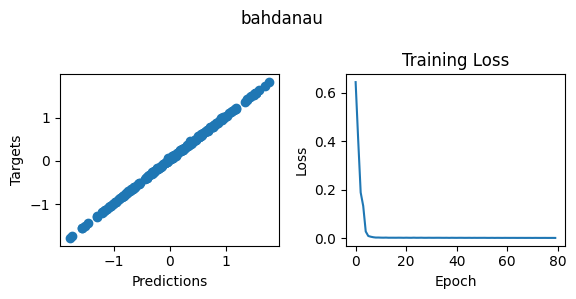

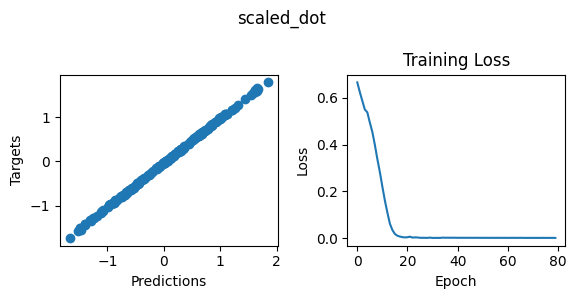

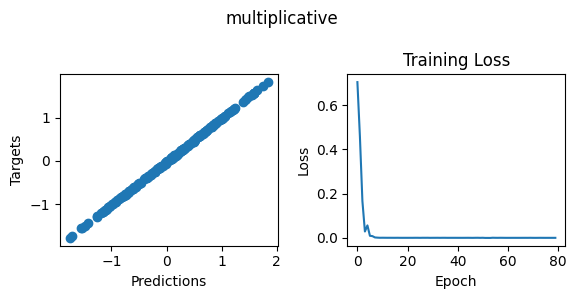

In [42]:
if __name__ == "__main__":
    set_seed()
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Configuration
    attention_type = "bahdanau"
    problem_type = "add"

    # Create dataset
    data = SequenceData(
        num_samples=default_args["num_samples"],
        max_seq_len=default_args["sequence_length"],
        k=default_args["k"],
        problem_type=problem_type,
        variable_len=True
    )
    for attention_type in ["bahdanau", "scaled_dot", "multiplicative"]:
        print("="*30 + attention_type + "="*30)
        # Create model with specified attention type
        set_seed()
        model = AttentionNetwork(
            input_dim=args["input_dim"],
            hidden_dim=args["hidden_dim"],
            query_dim=args["query_dim"],
            output_dim=args["output_dim"],
            attention_type=attention_type
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

        # Create trainer
        trainer = Trainer(
            batch_size=args["batch_size"],
            max_epochs=args["num_epochs"],
            gradient_clip_val=args["gradient_clip_val"],
            device=device
        )

        trainer.fit(model, data, optimizer)

        tr, val = trainer.get_dataloader(data)
        preds, targets, avg_loss = trainer.predict(model, val)
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        fig.suptitle(attention_type)
        axs[0].scatter(preds, targets)
        axs[0].set_xlabel("Predictions")
        axs[0].set_ylabel("Targets")
        axs[1].plot(trainer.train_loss)
        axs[1].set_ylabel("Loss")
        axs[1].set_xlabel("Epoch")
        axs[1].set_title("Training Loss")
        fig.tight_layout()



## Multi-head Self Attention

Now we will extend this problem to test whether a multi-head attention mechanism can learn to perform **different operations** on the **same sequence** but with **different marked positions**.

In the multi-dimensional problem, the model is given a sequence of 4D vectors:

|            | Pos 0 | Pos 1 | Pos 2 | Pos 3 | Pos 4 | ... | Pos 49 |
|------------|-------|-------|-------|-------|-------|-----|--------|
| **Values**     | 0.5   | -0.7  | 0.3   | 0.1   | -0.2  | ... | 0.2    |
| **Add markers**    | 0     | 0     | 1     | 0     | 0     | ... | 1      |
| **Mult markers**   | 1     | 0     | 0     | 0     | 1     | ... | 0      |
| **Avg markers**    | 0     | 1     | 0     | 1     | 0     | ... | 0      |

Where:
- **Dimension 0 (Values)**: Random numbers in [-1, 1] - **shared by all operations**
- **Dimension 1 (Add markers)**: Marks 2 positions for the addition operation
- **Dimension 2 (Mult markers)**: Marks 2 different positions for the multiplication operation  
- **Dimension 3 (Avg markers)**: Marks 2 different positions for the averaging operation

The model must compute three separate targets:
1. **Addition**: Sum of values at positions marked in dimension 1
   - Example: Values at positions 2 and 49 → `0.3 + 0.2 = 0.5`
2. **Multiplication**: Product of values at positions marked in dimension 2
   - Example: Values at positions 0 and 4 → `0.5 × (-0.2) = -0.1`
3. **Averaging**: Mean of values at positions marked in dimension 3
   - Example: Values at positions 1 and 3 → `(-0.7 + 0.1) / 2 = -0.3`

**Final target**: Average of the three operation results


In [16]:
class MultiHeadScaledDotProductAttention(nn.Module):
    """
    Multi-head scaled dot-product attention.

    Instead of performing a single attention operation, multi-head attention
    performs multiple attention operations in parallel (heads), then combines
    the results.
    """

    def __init__(self, hidden_dim: int, num_heads: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        ##########################################
        ## TODO: Initialize parameters, 0.3 points
        # Learnable query vector - one per head!, 0.2 points
        # Hint: Shape: (num_heads, hidden_dim, 1)
        self.queries = nn.Parameter(torch.randn(num_heads, hidden_dim, 1))
        # Aggregate all heads back to hidden_dim:
        # should be a parameter
        # Shape: (hidden_dim, num_heads * hidden_dim)
        self.head_aggregator = nn.Parameter(torch.randn(hidden_dim, num_heads * hidden_dim))
        ##########################################

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None,
                values: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input tensor (keys) of shape (batch_size, seq_len, hidden_dim)
            attention_mask: Optional mask of shape (batch_size, seq_len)
                          where True indicates positions to IGNORE
            values: Optional separate values tensor of shape (batch_size, seq_len, value_dim)
                  If None, use x as values (self-attention)
        """
        bs, seq_len, hidden_dim = x.shape
        # Use x as values if not provided (self-attention)
        if values is None:
            values = x
        ##########################################
        res = None
        attention_weights = torch.zeros((bs, self.num_heads, seq_len))
        ## TODO: Implement multi-head attention, 0.8 points
        # Compute energies for all heads at once
        # Hint: x: (bs, seq_len, hidden_dim)
        # queries: (num_heads, hidden_dim, 1)
        # Hint: You might find torch.einsum useful
        # https://docs.pytorch.org/docs/stable/generated/torch.einsum.html
        # energies: (bs, num_heads, seq_len)
        # Use different letters: b=batch, s=seq_len, d=hidden_dim, h=num_heads
        energies = torch.einsum('bsd,hdo->bhs', x, self.queries).squeeze(-1)

        # Scale by sqrt(hidden_dim)
        energies = energies / np.sqrt(hidden_dim)

        # Apply mask if provided
        if attention_mask is not None:
            # attention_mask: (bs, seq_len) -> (bs, 1, seq_len)
            energies = energies.masked_fill(attention_mask.unsqueeze(1), float('-inf'))

        # Apply softmax
        # attention_weights: (bs, num_heads, seq_len)
        attention_weights = F.softmax(energies, dim=-1)

        # Apply attention weights to values for all heads
        # values: (bs, seq_len, hidden_dim)
        # attention_weights: (bs, num_heads, seq_len)
        # head_outputs: (bs, num_heads, hidden_dim)
        head_outputs = torch.einsum('bhs,bsd->bhd', attention_weights, values)

        # Concatenate all heads: (bs, num_heads, hidden_dim) -> (bs, num_heads * hidden_dim)
        head_outputs_concat = head_outputs.reshape(bs, self.num_heads * hidden_dim)

        # Aggregate from multi-heads back to hidden_dim
        # head_outputs_concat: (bs, num_heads * hidden_dim)
        # head_aggregator: (hidden_dim, num_heads * hidden_dim)
        # res: (bs, hidden_dim)
        res = torch.matmul(head_outputs_concat, self.head_aggregator.T)
        ##########################################
        assert attention_weights.shape == (bs, self.num_heads, seq_len)
        return res, attention_weights

In [17]:
## don't change the following code
class MultiHeadAttentionNetwork(AttentionNetwork):
    """
    Complete network with attention pooling.
    Architecture: Dense -> Attention -> Dense -> Output
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        query_dim: int,
        output_dim: int,
        num_heads: int,
        attention_type: Literal["scaled_dot"] = "scaled_dot"
    ):
        super().__init__(input_dim, hidden_dim, query_dim, output_dim, attention_type)
        # Over-write the attention module
        self.attention_module = MultiHeadScaledDotProductAttention(hidden_dim, num_heads)

In [18]:
## don't change the following code

PADDING_ID = 100
NUM_SAMPLES = 1000
MAX_SEQ_LEN = 50

class MultiDimSequenceData(SequenceData):
    def __init__(
        self,
        num_samples: int = NUM_SAMPLES,
        max_seq_len: int = MAX_SEQ_LEN,
        padding_id: int = PADDING_ID,
        k: int = 2,
        variable_len: bool = False,
    ) -> None:
        """
        Args:
            k: Number of positions to mark
            variable_len: If True, generate sequences of random length between k and max_seq_len
        """
        super().__init__()
        self.padding_id = padding_id
        self.k = k
        self.max_seq_len = max_seq_len
        data = []
        for _ in range(num_samples):
            sequence_length=random.randint(k, MAX_SEQ_LEN)
            sequence = np.zeros((sequence_length, 4))
            # input values
            sequence[:, 0] = np.random.uniform(-1, 1, sequence_length)
            targets = []
            for ind, problem_type in enumerate(["add", "multiply", "average"], 1):
                random_indices = np.random.choice(sequence_length, size=k, replace=False)
                sequence[random_indices, ind] = 1
                marked_values = sequence[random_indices, 0]
                if problem_type == "add":
                    target = marked_values.sum()
                elif problem_type == "multiply":
                    target = marked_values.prod()
                elif problem_type == "average":
                    target = marked_values.mean()
                targets.append(target)
            x = torch.tensor(sequence, dtype=torch.float32)
            y = torch.tensor([np.mean(targets)], dtype=torch.float32)
            data.append((x, y))
        self.X = [d[0] for d in data]
        self.y = [d[1] for d in data]

Epoch 10/70, Train Loss: 0.0283, Val Loss: 0.0286
Epoch 20/70, Train Loss: 0.0122, Val Loss: 0.0161
Epoch 30/70, Train Loss: 0.0100, Val Loss: 0.0139
Epoch 40/70, Train Loss: 0.0059, Val Loss: 0.0059
Epoch 50/70, Train Loss: 0.0047, Val Loss: 0.0046
Epoch 60/70, Train Loss: 0.0040, Val Loss: 0.0049
Epoch 70/70, Train Loss: 0.0030, Val Loss: 0.0031


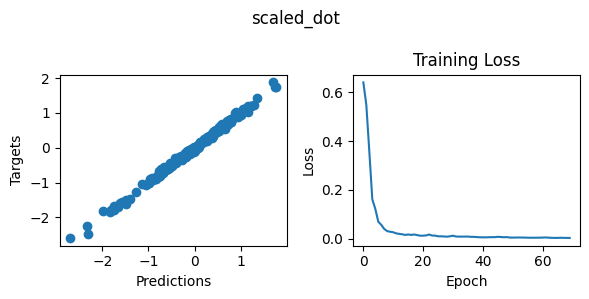

In [45]:
multi_default_args = {
    "sequence_length": 50,
    "num_samples": 1000,
    "k": 16,
    "print_every": 10
}
multi_args = {
    "batch_size": 100,
    "num_epochs": 70,
    "lr": 0.01,
    "hidden_dim": 10,
    "query_dim": 10,
    "input_dim": 4,
    "output_dim": 1,
    "gradient_clip_val": None,
    "num_heads": 3
}
if __name__ == "__main__":
    set_seed()
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Configuration
    attention_type = "scaled_dot"

    # Create dataset
    data = MultiDimSequenceData(
        num_samples=multi_default_args["num_samples"],
        max_seq_len=multi_default_args["sequence_length"],
        k=multi_default_args["k"],
        variable_len=True
    )

    # Create model with specified attention type
    model = MultiHeadAttentionNetwork(
        input_dim=multi_args["input_dim"],
        hidden_dim=multi_args["hidden_dim"],
        query_dim=multi_args["query_dim"],
        output_dim=multi_args["output_dim"],
        num_heads=multi_args["num_heads"],
        attention_type=attention_type
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=multi_args["lr"])

    # Create trainer
    trainer = Trainer(
        batch_size=multi_args["batch_size"],
        max_epochs=multi_args["num_epochs"],
        gradient_clip_val=multi_args["gradient_clip_val"],
        device=device
    )

    trainer.fit(model, data, optimizer)

    tr, val = trainer.get_dataloader(data)
    preds, targets, avg_loss = trainer.predict(model, val)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(attention_type)
    axs[0].scatter(preds, targets)
    axs[0].set_xlabel("Predictions")
    axs[0].set_ylabel("Targets")
    axs[1].plot(trainer.train_loss)
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Training Loss")
    fig.tight_layout()


# Collaboration / External Help
Disclose any help you used (LLM usage, blogs, search, Github links, etc) and collaborations with your classmates. If you  completed the homework on your own, you can leave this part empty.

> TODO